In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

from mantis_shrimp import datasets
from mantis_shrimp import extract_magnitude

In [2]:
def luptitude(a,alpha=0.1,Q=6.0,minimum=0.0):
    #I = np.mean(a,0) #average values across each pixel,
    #M = minimum + np.sinh(Q)/(alpha*Q),
    aimg = (np.arcsinh(alpha*Q*(a - minimum))/Q)
    return aimg

In [3]:
loaded = np.load('/rcfs/projects/mantis_shrimp/Adam/FluxDictionaryValTestCalib.npz')
loaded_dict = {key: loaded[key] for key in loaded.keys()}

In [4]:
loaded = np.load('/rcfs/projects/mantis_shrimp/Adam/FluxDictionaryValTestCalib.npz')
loaded_dict = {key: loaded[key] for key in loaded.keys()}

combined_mask_WPS_val = []
combined_mask_WPS_test = []
combined_csfd_val = []
combined_csfd_test = []
combined_planck_val = []
combined_planck_test = []

for kind in ['val']:
    for rank in tqdm(range(16)):
        MSD = datasets.MantisShrimpDataset(kind=kind,WORLD_RANK=rank,ZMAX=1.6,mmap=True,transform=False,sep=False,)
        data = loaded_dict[f'{kind}_{rank}_fluxes']

        WPS_mask = ~np.isnan(MSD.zphot_WPS)
        csfd = MSD.ebv_csfd
        planck = MSD.ebv_planck
        combined_csfd_val.extend(csfd)
        combined_planck_val.extend(planck)
        combined_mask_WPS_val.extend(WPS_mask)

        loaded_dict[f'{kind}_{rank}_fluxes'] = luptitude(data)
        
for kind in ['test']:
    for rank in tqdm(range(16)):
        MSD = datasets.MantisShrimpDataset(kind=kind,WORLD_RANK=rank,ZMAX=1.6,mmap=True,transform=False,sep=False,)
        data = loaded_dict[f'{kind}_{rank}_fluxes']

        WPS_mask = ~np.isnan(MSD.zphot_WPS)
        csfd = MSD.ebv_csfd
        planck = MSD.ebv_planck

        combined_csfd_test.extend(csfd)
        combined_planck_test.extend(planck)
        combined_mask_WPS_test.extend(WPS_mask)

        loaded_dict[f'{kind}_{rank}_fluxes'] = luptitude(data)
        

combined_mask_WPS_val = np.array(combined_mask_WPS_val)
combined_mask_WPS_test = np.array(combined_mask_WPS_test)
combined_csfd_val = np.array(combined_csfd_val)
combined_csfd_test = np.array(combined_csfd_test)
combined_planck_val = np.array(combined_planck_val)
combined_planck_test = np.array(combined_planck_test)

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [03:17<00:00, 12.35s/it]


In [5]:
#loaded_diff = np.load('/rcfs/projects/mantis_shrimp/Adam/FluxDifferencesDictionaryValTestCalib.npz')
#FluxDifferencesDictionary = {key: loaded_diff[key] for key in loaded_diff.keys()}

In [6]:
def pairwise_row_differences(arr):
    if len(arr.shape) != 2:
        raise ValueError("Input must be a 2D NumPy array.")
    n = arr.shape[0]
    differences = arr[:, np.newaxis, :] - arr[np.newaxis, :, :]
    return differences

In [7]:
kind='val'
luptitude_val = [loaded_dict[f'{kind}_{rank}_fluxes'] for rank in range(16)]
luptitude_val = np.concatenate(luptitude_val,0)

kind='test'
luptitude_test = [loaded_dict[f'{kind}_{rank}_fluxes'] for rank in range(16)]
luptitude_test = np.concatenate(luptitude_test,0)

In [8]:
kind='val'
val_diff = []
for rank in range(16):
    diff = pairwise_row_differences(loaded_dict[f'{kind}_{rank}_fluxes'].T)
    val_diff.append(diff)

kind='test'
test_diff = []
for rank in range(16):
    diff = pairwise_row_differences(loaded_dict[f'{kind}_{rank}_fluxes'].T)
    test_diff.append(diff)

val_diff = np.concatenate(val_diff,axis=2)
test_diff = np.concatenate(test_diff,axis=2)

from einops import rearrange
val_diff = rearrange(val_diff,'a b c -> c (a b)')
mask = np.all(val_diff==0, axis = 0)
val_diff = val_diff[:,~mask]

test_diff = rearrange(test_diff,'a b c -> c (a b)')
mask = np.all(test_diff==0, axis = 0)
test_diff = test_diff[:,~mask]

In [9]:
data = np.concatenate([val_diff,combined_csfd_val[:,None], combined_planck_val[:,None], luptitude_val],axis=1)
test_data = np.concatenate([test_diff,combined_csfd_test[:,None], combined_planck_test[:,None], luptitude_test],axis=1)

In [10]:
DataDict = np.load('/rcfs/projects/mantis_shrimp/mantis_shrimp/data/completed_analysis/data_dict_large.npy', allow_pickle = True).item()

In [11]:
cov_grid = np.linspace(0.001, 0.999, 201)

In [12]:
x_test = (test_data-np.mean(data, axis = 0))/np.std(data, axis = 0)/3
x_calib = (data-np.mean(data, axis = 0))/np.std(data, axis = 0)/3

In [13]:
from calpit.utils import normalize

In [14]:
cde_cali = normalize((DataDict['all_cde_hat_val']+1e-2)/np.sum(DataDict['all_cde_hat_val']+1e-2, axis = 1)[:,None], np.linspace(0,1.6,400))
cde_test = normalize((DataDict['all_cde_hat_test']+1e-2)/np.sum(DataDict['all_cde_hat_test']+1e-2, axis = 1)[:,None], np.linspace(0,1.6,400))

In [15]:
og_cde_test = normalize(DataDict['all_cde_hat_test'],np.linspace(0,1.6,400))

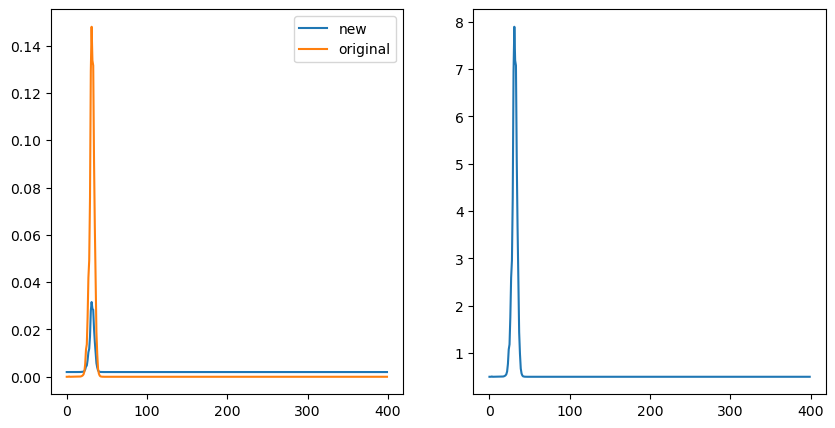

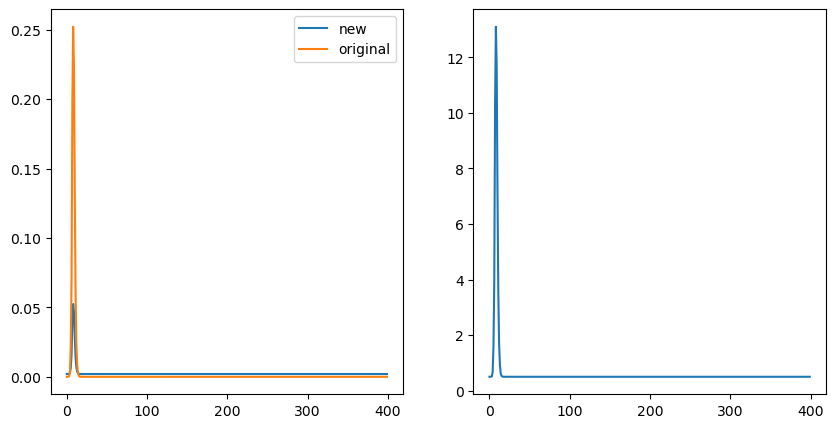

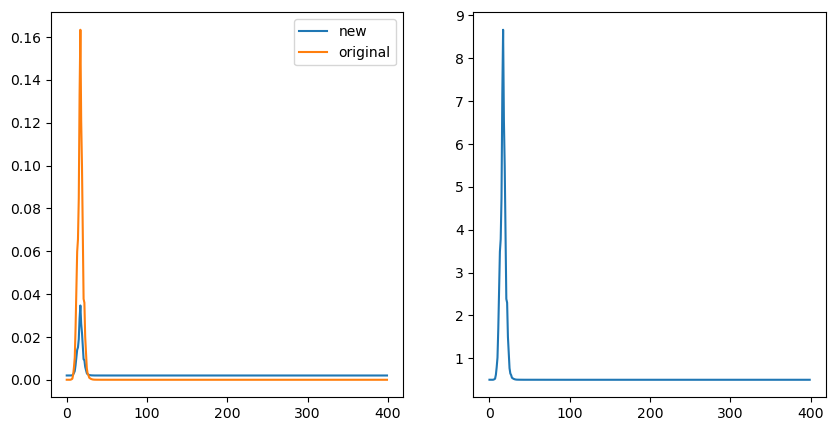

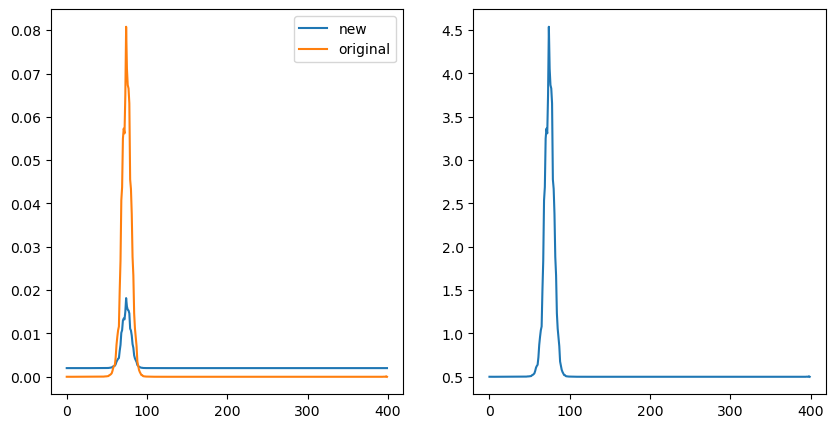

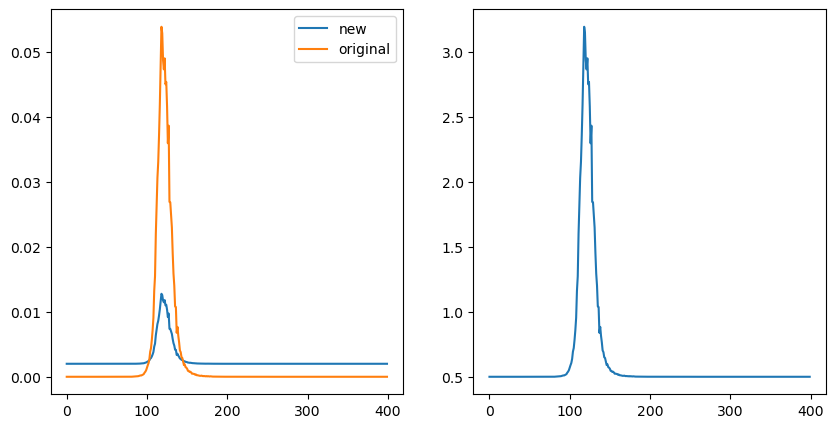

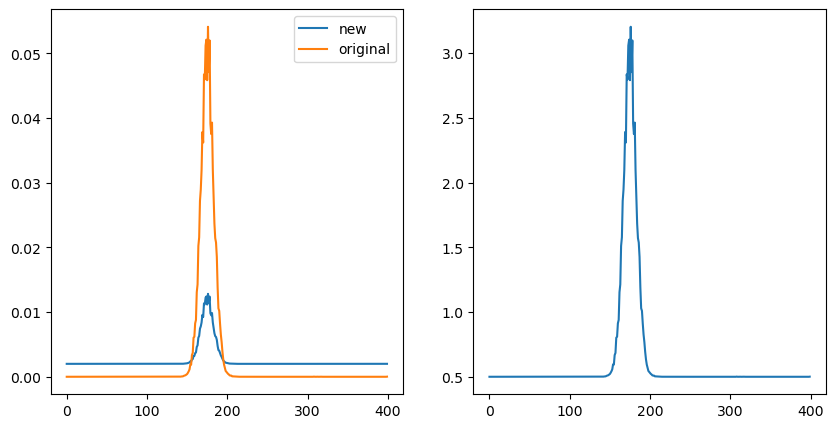

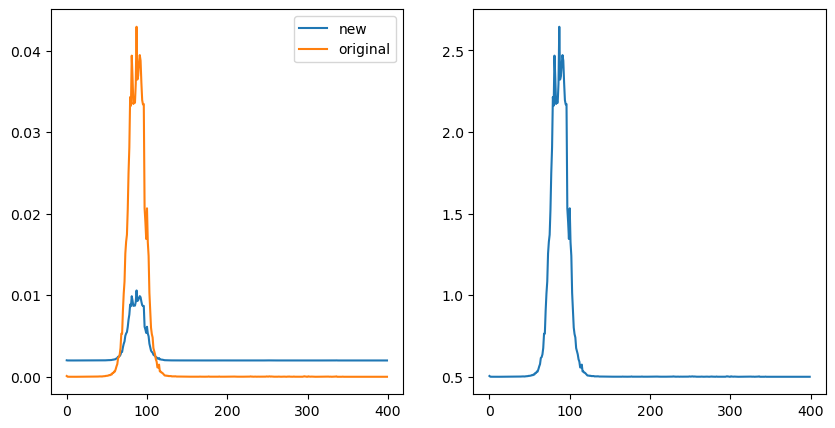

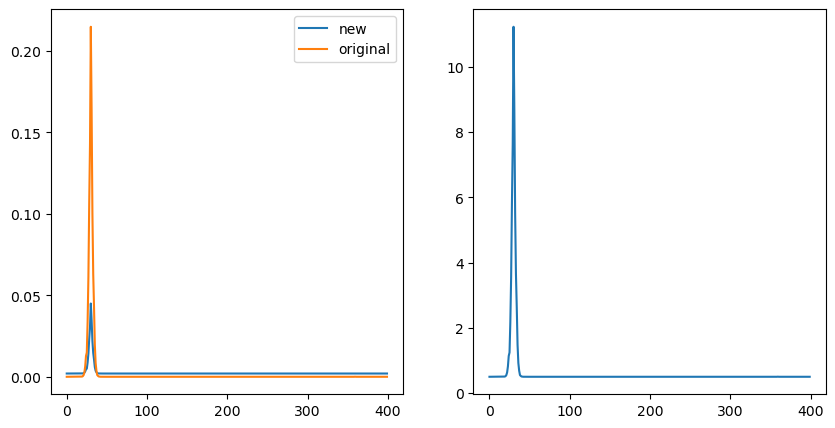

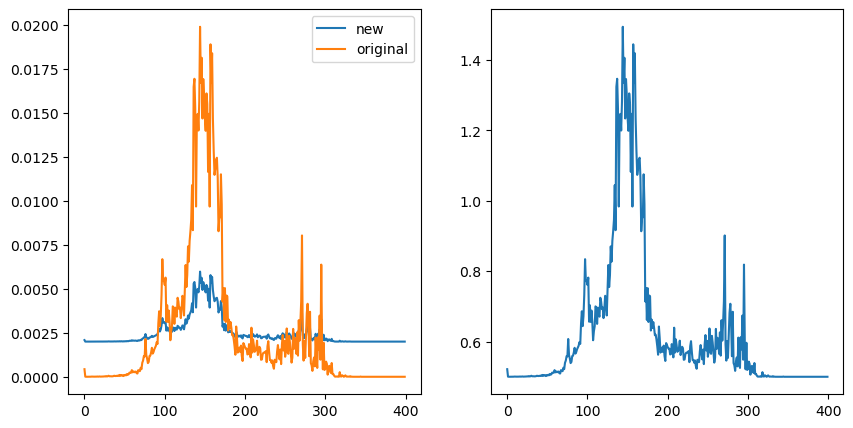

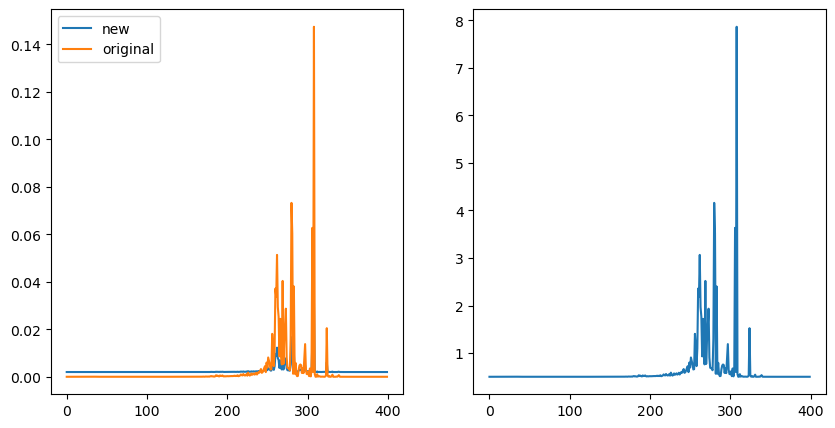

In [16]:
for i in range(10):
    i = int(np.random.random()*len(DataDict['all_cde_hat_val']))

    fig = plt.figure(figsize=(10,5))
    vls = (DataDict['all_cde_hat_val'][i]+1e-2)/np.sum(DataDict['all_cde_hat_val'][i]+1e-2)

    plt.subplot(1,2,1)
    plt.plot(vls,label='new')
    plt.plot(DataDict['all_cde_hat_val'][i],label='original')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cde_cali[i])
    plt.show()

In [17]:
from calpit import CalPit
from calpit.nn.umnn import MonotonicNN 
model = MonotonicNN(84, [1024,1024,1024,1024], sigmoid=True)
device = torch.device('cuda')
model.to(device)
calpit_model = CalPit(model=model)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| integrand.net.0.weight |   86016    |
|  integrand.net.0.bias  |    1024    |
| integrand.net.2.weight |  1048576   |
|  integrand.net.2.bias  |    1024    |
| integrand.net.4.weight |  1048576   |
|  integrand.net.4.bias  |    1024    |
| integrand.net.6.weight |  1048576   |
|  integrand.net.6.bias  |    1024    |
| integrand.net.8.weight |    1024    |
|  integrand.net.8.bias  |     1      |
|      net.0.weight      |   84992    |
|       net.0.bias       |    1024    |
|      net.2.weight      |  1048576   |
|       net.2.bias       |    1024    |
|      net.4.weight      |  1048576   |
|       net.4.bias       |    1024    |
|      net.6.weight      |  1048576   |
|       net.6.bias       |    1024    |
|      net.8.weight      |    2048    |
|       net.8.bias       |     2      |
+------------------------+------------+
Total Trainable Params: 6473731


In [18]:
y_calib = DataDict['data_y_eval_val']
y_calib_test = DataDict['data_y_eval_test']

In [19]:
y_grid = np.linspace(0,1.6,400)

In [20]:
torch.cuda.empty_cache()
import gc
gc.collect()

53812

In [25]:
trained_model = calpit_model.fit(x_calib,
                                 y_calib,
                                 cde_cali,
                                 y_grid,
                                 lr=1e-3,
                                 weight_decay=1e-5,
                                 num_workers=16,
                                 batch_size=512,
                                 n_epochs=100)

[  1/100] | train_loss: 0.21312 |valid_bce: 0.19581 | 
Validation loss decreased (inf --> 0.195814).  Saving model ...
[  2/100] | train_loss: 0.19947 |valid_bce: 0.19666 | 
EarlyStopping counter: 1 out of 20
[  3/100] | train_loss: 0.19702 |valid_bce: 0.19399 | 
Validation loss decreased (0.195814 --> 0.193993).  Saving model ...
[  4/100] | train_loss: 0.19635 |valid_bce: 0.19634 | 
EarlyStopping counter: 1 out of 20
[  5/100] | train_loss: 0.19572 |valid_bce: 0.19398 | 
Validation loss decreased (0.193993 --> 0.193983).  Saving model ...
[  6/100] | train_loss: 0.19572 |valid_bce: 0.19375 | 
Validation loss decreased (0.193983 --> 0.193749).  Saving model ...
[  7/100] | train_loss: 0.19288 |valid_bce: 0.19203 | 
Validation loss decreased (0.193749 --> 0.192028).  Saving model ...
[  8/100] | train_loss: 0.19447 |valid_bce: 0.19483 | 
EarlyStopping counter: 1 out of 20
[  9/100] | train_loss: 0.19314 |valid_bce: 0.19217 | 
EarlyStopping counter: 2 out of 20
[ 10/100] | train_loss: 0

In [26]:
torch.cuda.empty_cache()
import gc
gc.collect()

10

In [21]:
ckpt = torch.load('./_results/checkpoint_.pt')

In [22]:
calpit_model.model.load_state_dict(ckpt)

<All keys matched successfully>

In [29]:
new_cde = calpit_model.transform(x_test, cde_test, y_grid, batch_size=16) #Recalibrate the conditional density estimate for a test dataset

  6%|████▏                                                                       | 2999/53749 [19:29<5:29:59,  2.56it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
#np.save('../data/completed_analysis/new_cde.npy',new_cde)

In [23]:
new_cde = np.load('../data/completed_analysis/new_cde.npy',)

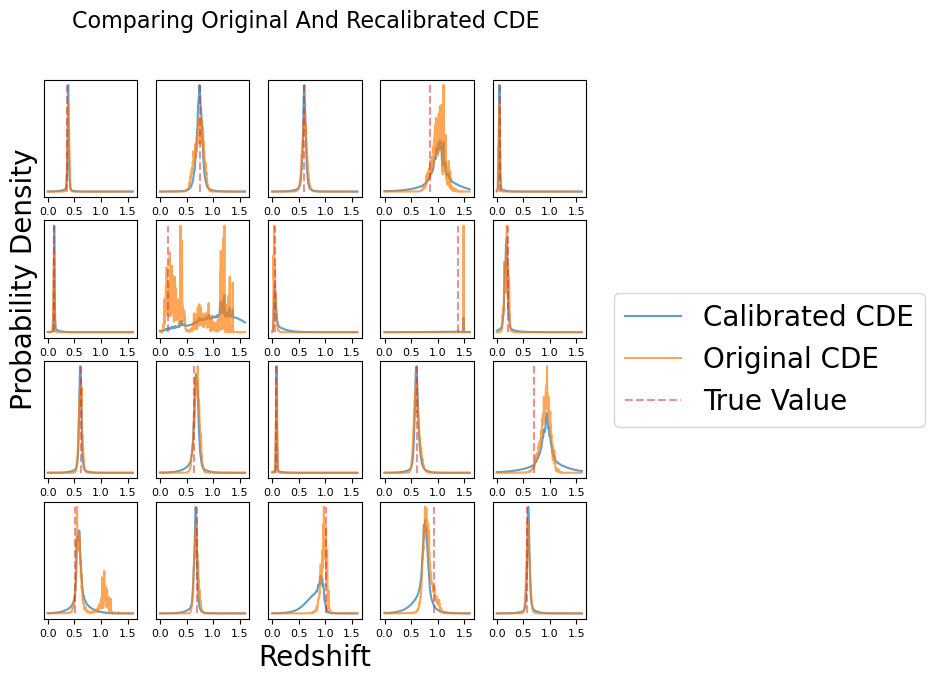

In [26]:
counter=1
fig = plt.figure(figsize=(7,7))
for i in range(0,1600,25):

    plt.subplot(4,5,counter)
    plt.plot(np.linspace(0,1.6,400),new_cde[i],label='Calibrated CDE',alpha=0.7)
    plt.plot(np.linspace(0,1.6,400),og_cde_test[i],label='Original CDE',alpha=0.7)

    maxi = max([np.max(og_cde_test[i]),np.max(new_cde[i])])
    plt.vlines(y_calib_test[i],0,maxi,color='tab:red',linestyle='dashed',linewidth=1.5,label='True Value',alpha=0.5)
    plt.yticks([])
    plt.xticks([0,0.5,1.0,1.5],fontsize=8)
    
    if counter==18:
        plt.xlabel('Redshift',fontsize=20)
    if counter==6:
        plt.ylabel('Probability Density',fontsize=20)
    if counter == 10:
        plt.legend(bbox_to_anchor=(1.15,0.5),fontsize=20)
    
    if counter == 20:
        break

    counter+=1

plt.suptitle('Comparing Original And Recalibrated CDE',fontsize=16)
plt.savefig('../IMAGES/CALPIT_vis_cde_samples.png',dpi=600,bbox_inches='tight')
plt.show()


In [25]:
from calpit.metrics import cde_loss

normalized_old_cde_loss = cde_loss(cde_test, np.linspace(0,1.6,400), y_calib_test)
normalized_new_cde_loss = cde_loss(new_cde, np.linspace(0,1.6,400), y_calib_test)
normalized_og_cde_loss = cde_loss(og_cde_test, np.linspace(0,1.6,400),y_calib_test)
WPS_new_cde_loss = cde_loss(new_cde[combined_mask_WPS_test], np.linspace(0,1.6,400),y_calib_test[combined_mask_WPS_test])

print(normalized_old_cde_loss)
print('New cde_loss: {:.4f} +/- {:.4f}'.format(normalized_new_cde_loss[0],normalized_new_cde_loss[1]))
print('Original cde_loss: {:.4f} +/- {:.4f}'.format(normalized_og_cde_loss[0],normalized_og_cde_loss[1]))
print('WPS Only cde_loss: {:.4f} +/- {:.4f}'.format(WPS_new_cde_loss[0],WPS_new_cde_loss[1]))


(-4.469305353629561, 0.006965427702819554)
New cde_loss: -10.1625 +/- 0.0227
Original cde_loss: -7.9784 +/- 0.0372
WPS Only cde_loss: -12.4051 +/- 0.0288


In [26]:
from calpit.metrics import probability_integral_transform
from calpit.utils import plot_pit
import matplotlib.pyplot as plt

new_cde_pit = probability_integral_transform(new_cde, np.linspace(0,1.6,400), y_calib_test)
old_cde_pit = probability_integral_transform(cde_test, np.linspace(0,1.6,400), y_calib_test)
og_cde_pit = probability_integral_transform(og_cde_test, np.linspace(0,1.6,400), y_calib_test)

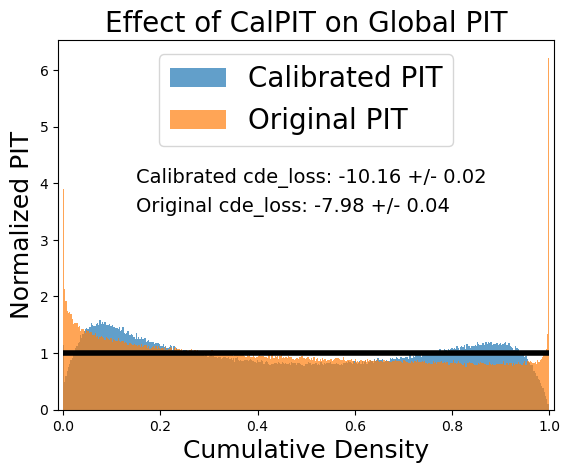

In [30]:
plt.hist(new_cde_pit, bins = 400, alpha = .7, label = 'Calibrated PIT',density=True)
plt.hist(og_cde_pit, bins = 400, alpha = .7, label = 'Original PIT',density=True)

plt.hlines(1.0,0.0,1.0,color='k',linewidth=4)

plt.legend(fontsize=20,loc='upper center')
plt.title('Effect of CalPIT on Global PIT',fontsize=20)
plt.ylabel('Normalized PIT',fontsize=18)
plt.xlabel('Cumulative Density',fontsize=18)
plt.text(0.15,4,'Calibrated cde_loss: {:.2f} +/- {:.2f}'.format(normalized_new_cde_loss[0],normalized_new_cde_loss[1]),fontsize=14)
plt.text(0.15,3.5,'Original cde_loss: {:.2f} +/- {:.2f}'.format(normalized_og_cde_loss[0],normalized_og_cde_loss[1]),fontsize=14)
plt.xlim(-0.01,1.01)
plt.savefig('../IMAGES/calpit_PIT_comparison.png',dpi=600)
plt.show()

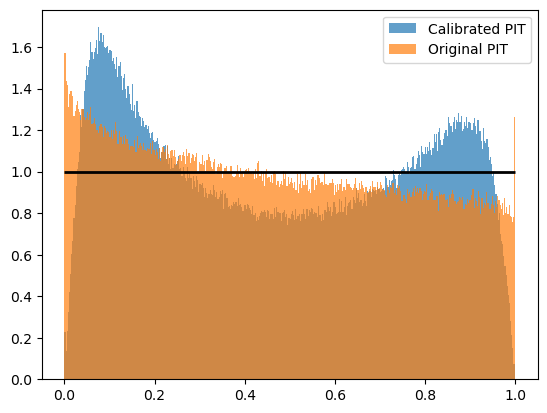

In [41]:
plt.hist(new_cde_pit[combined_mask_WPS_test], bins = 400, alpha = .7, label = 'Calibrated PIT',density=True)
plt.hist(og_cde_pit[combined_mask_WPS_test], bins = 400, alpha = .7, label = 'Original PIT',density=True)

plt.hlines(1.0,0.0,1.0,color='k',linewidth=2)

plt.legend()
plt.show()

# So ... how badly does that impact performance?

In [47]:
DataDict = np.load('/rcfs/projects/mantis_shrimp/mantis_shrimp/data/completed_analysis/data_dict_large.npy', allow_pickle = True).item()

In [53]:
print(new_cde[515712])

#huh

#in this case, return uniform.

new_cde[515712] = 1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [54]:
#renormalize my cde to PMFs to apply my analysis chain
new_pmf = new_cde / np.sum(new_cde,1)[:,None]
old_pmf = DataDict['all_cde_hat_test']

In [55]:
predictions_new = np.sum(new_pmf * np.linspace(0.0,1.6,400),axis=1)
predictions_old = np.sum(old_pmf * np.linspace(0.0,1.6,400),axis=1)

In [56]:
#predictions new
residuals_scaled = (predictions_new - y_calib_test)/(1+y_calib_test)

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My (new) Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')

print('\n')

#predictions old
residuals_scaled = (predictions_old - y_calib_test)/(1+y_calib_test)

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My (old) Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')


My (new) Performance on the Entire Dataset: 
MAD:  0.028235
BIAS:  0.005743
ETA:  21.506264 % >0.05


My (old) Performance on the Entire Dataset: 
MAD:  0.02444
BIAS:  0.012265
ETA:  17.677696 % >0.05


In [57]:
#predictions new
residuals_scaled = ((predictions_new - y_calib_test)/(1+y_calib_test))[combined_mask_WPS_test]

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My (new) Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')

print('\n')

#predictions old
residuals_scaled = ((predictions_old - y_calib_test)/(1+y_calib_test))[combined_mask_WPS_test]

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My (old) Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')


My (new) Performance on the Entire Dataset: 
MAD:  0.02113
BIAS:  -0.000175
ETA:  9.207586 % >0.05


My (old) Performance on the Entire Dataset: 
MAD:  0.018674
BIAS:  0.00352
ETA:  6.66233 % >0.05


In [58]:
import seaborn as sns

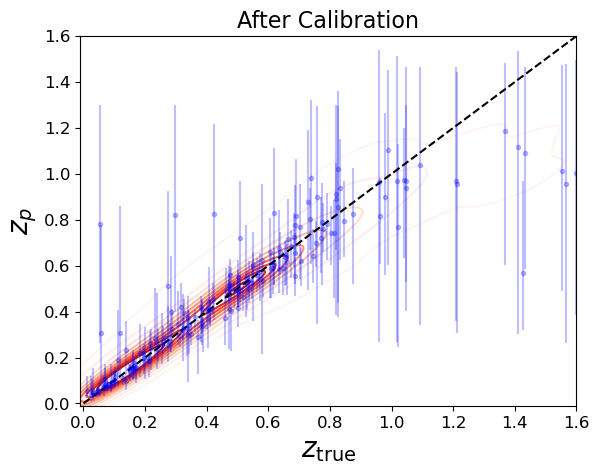

In [59]:
residual = (predictions_new - y_calib_test)/(1+y_calib_test)
#essentially, no residual mask. just to lazy to remove.
residual_mask = np.ones(len(residual),dtype=bool)


CLASS_BINS = np.linspace(0.0,1.6,400)
MAX_Z = 1.6
#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(new_pmf,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index][residual_mask] - predictions_new[residual_mask]
value_below = predictions_new[residual_mask] - CLASS_BINS[below_index][residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=y_calib_test[::500],y=predictions_new[::500],cmap='Reds',)
plt.errorbar(x=y_calib_test[residual_mask][::5000],y=predictions_new[residual_mask][::5000],yerr=np.array([value_below,value_above])[:,::5000],fmt='b.',alpha=0.25)
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=20)
plt.ylabel(r'$z_{p}$',fontsize=20)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.01,MAX_Z)
plt.ylim(-0.01,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'After Calibration',fontsize=16)
plt.savefig(f'./../IMAGES/calpit_after_calibration_random_errors_KDE.png',bbox_inches="tight",dpi=600)
plt.show()

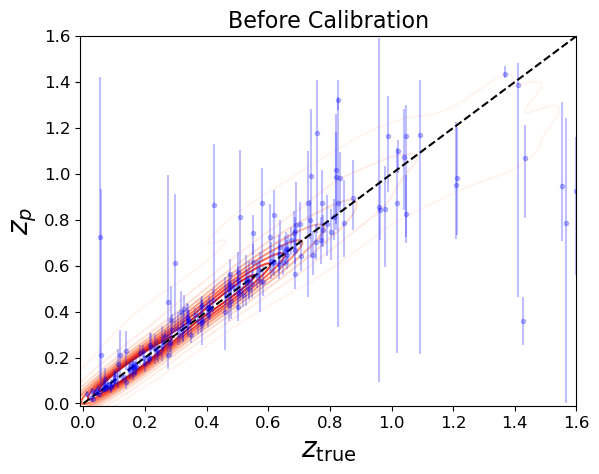

In [60]:
residual = (predictions_old - y_calib_test)/(1+y_calib_test)
#essentially, no residual mask. just to lazy to remove.
residual_mask = np.ones(len(residual),dtype=bool)


CLASS_BINS = np.linspace(0.0,1.6,400)
MAX_Z = 1.6
#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(old_pmf,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index][residual_mask] - predictions_old[residual_mask]
value_below = predictions_old[residual_mask] - CLASS_BINS[below_index][residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=y_calib_test[::500],y=predictions_old[::500],cmap='Reds',)
plt.errorbar(x=y_calib_test[residual_mask][::5000],y=predictions_old[residual_mask][::5000],yerr=np.array([value_below,value_above])[:,::5000],fmt='b.',alpha=0.25)
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=20)
plt.ylabel(r'$z_{p}$',fontsize=20)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.01,MAX_Z)
plt.ylim(-0.01,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Before Calibration',fontsize=16)
plt.savefig(f'./../IMAGES/calpit_before_calibration_random_errors_KDE.png',bbox_inches="tight",dpi=600)
plt.show()

# Now check that the model is locally calibrated--

# we aren't really given a clear answer on how this is achieved???

# ideas: 
* use tomographic bins in true redshift to check the calibration.
* use an image of g-r, r-W1 to check the calibration
* Use PCA on features to find vectors of the maximum variance, then create 2D plot of CvM on the grid


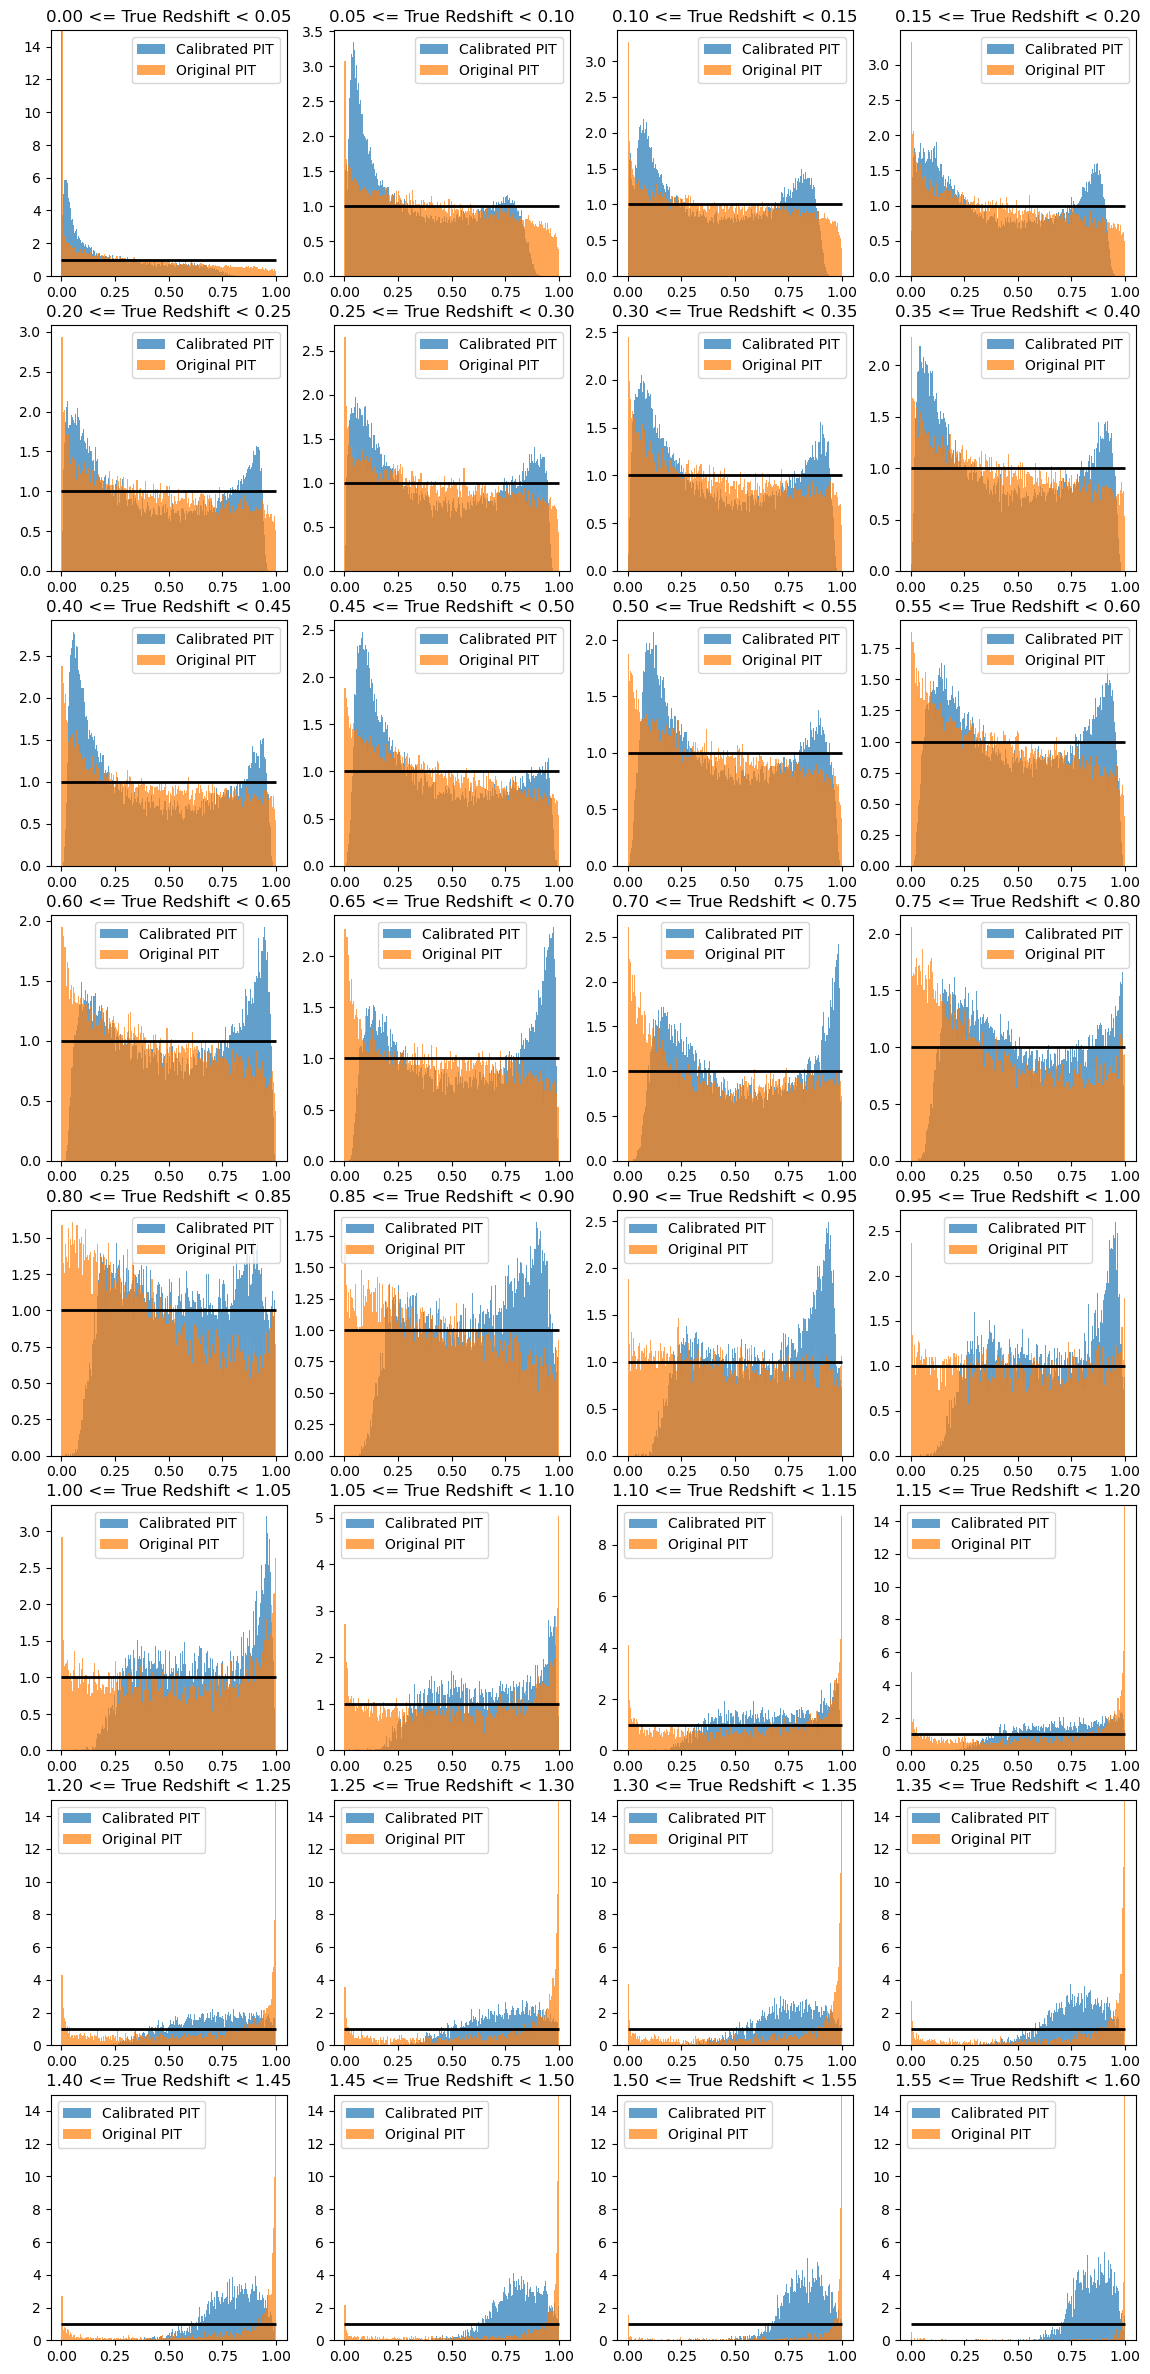

In [61]:
#first lets look at tomographic bins in true redshift

fig = plt.figure(figsize=(14,30))

for j,i in enumerate(np.linspace(0.0,1.6,33)[0:-1]):
    plt.subplot(8,4,j+1)
    mask = np.logical_and(y_calib_test>=i,y_calib_test<i+0.05)
    
    n1, __, __  = plt.hist(new_cde_pit[mask], bins = 200, alpha = .7, label = 'Calibrated PIT',density=True)
    n2, __, __  = plt.hist(og_cde_pit[mask], bins = 200, alpha = .7, label = 'Original PIT',density=True)
    maxi = max([np.max(n1),np.max(n2)])
    if maxi > 15:
        plt.ylim(0,15)
    plt.title('{:.2f} <= True Redshift < {:.2f}'.format(i,i+0.05))
    plt.hlines(1.0,0.0,1.0,color='k',linewidth=2)
    
    
    plt.legend()

plt.savefig('../IMAGES/calpit_localfeature_redshift.png',dpi=600)
plt.show()


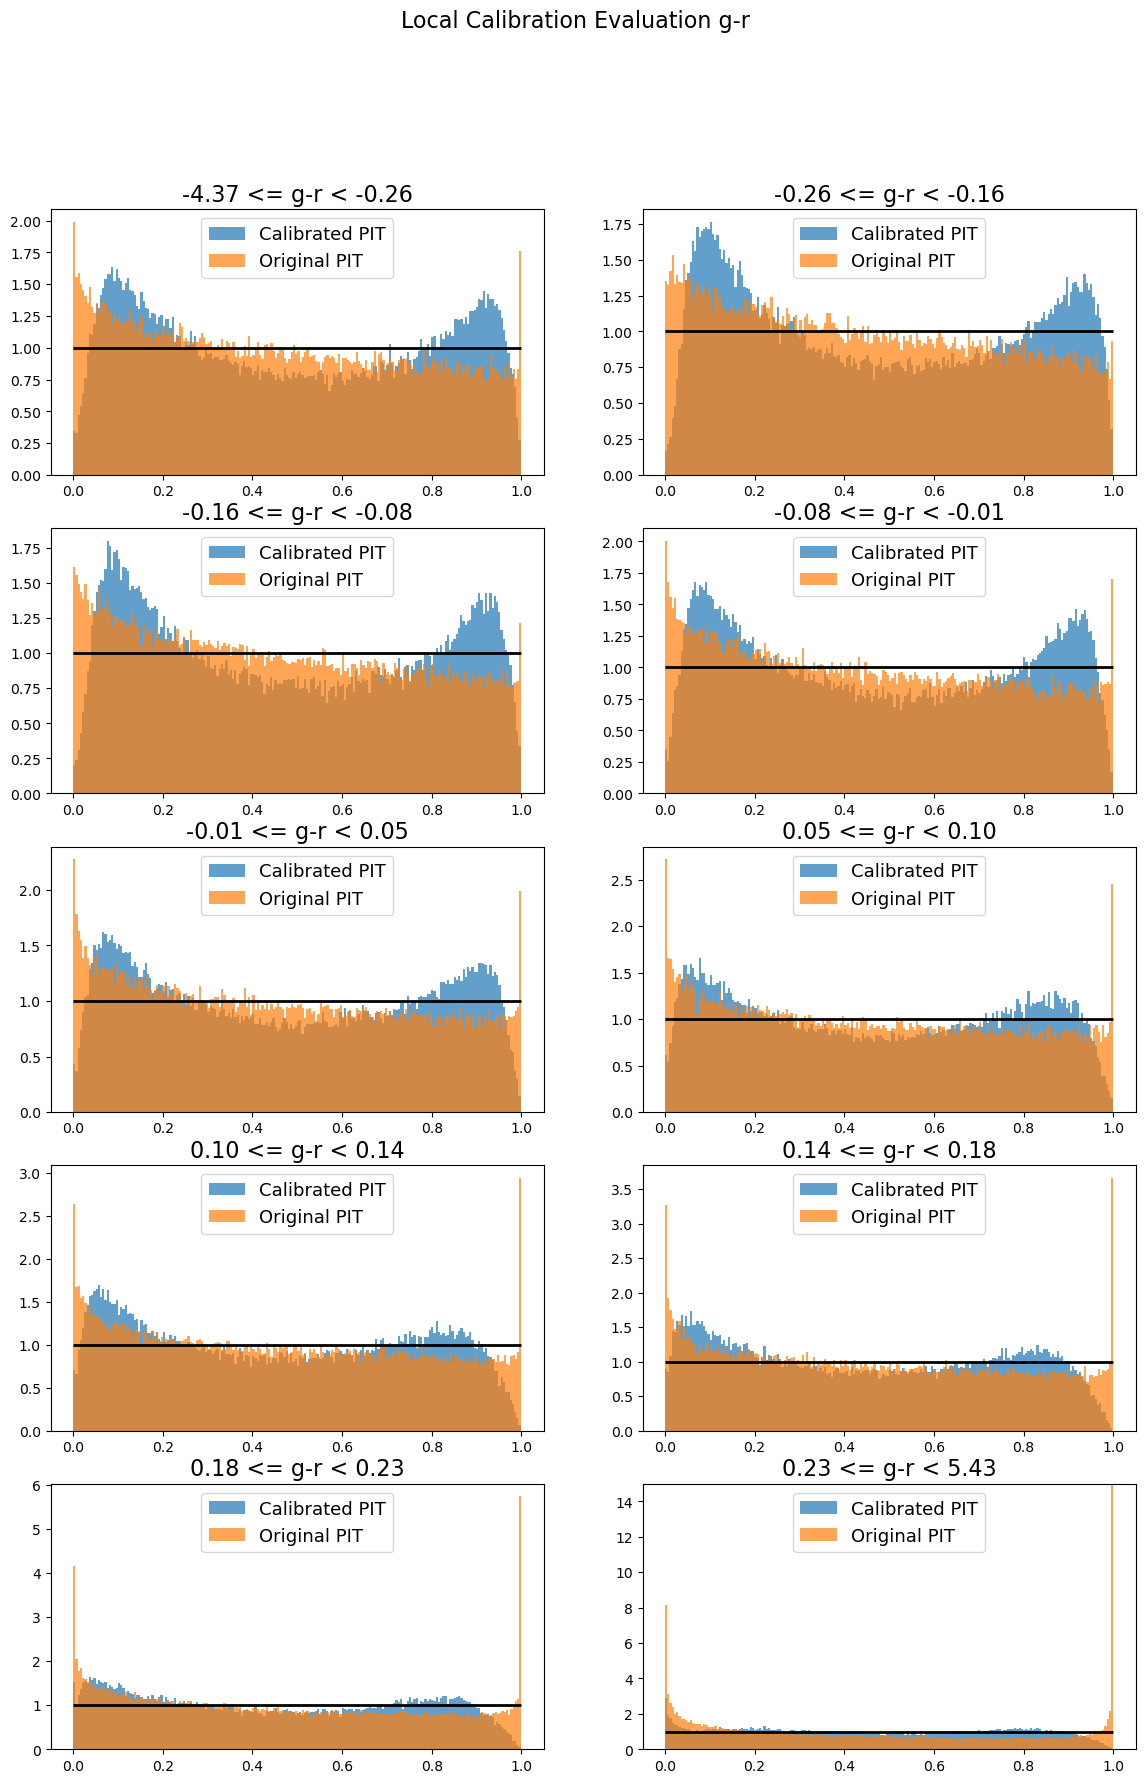

In [62]:
# quantiles in g-r
#g-r = 18
#r-W1 = 30
#i-W2 = 39
INDEX = 18
qBINS = np.linspace(0,1,11)
qs = np.quantile(x_test[:,INDEX],qBINS)


fig = plt.figure(figsize=(14,20))
for j,i in enumerate(qs[0:-1]):
    plt.subplot(5,2,j+1)
    mask = np.logical_and(qs[j]<=x_test[:,INDEX],x_test[:,INDEX]<qs[j+1])

    n1, __, __  = plt.hist(new_cde_pit[mask], bins = 200, alpha = .7, label = 'Calibrated PIT',density=True)
    n2, __, __  = plt.hist(og_cde_pit[mask], bins = 200, alpha = .7, label = 'Original PIT',density=True)
    maxi = max([np.max(n1),np.max(n2)])
    if maxi > 15:
        plt.ylim(0,15)
    plt.title('{:.2f} <= g-r < {:.2f}'.format(qs[j],qs[j+1]),fontsize=16)
    plt.hlines(1.0,0.0,1.0,color='k',linewidth=2)
    
    plt.legend(loc='upper center',fontsize=13)

plt.suptitle('Local Calibration Evaluation g-r',fontsize=16)
plt.savefig('../IMAGES/calpit_localfeature_gr.png',dpi=600)
plt.show()

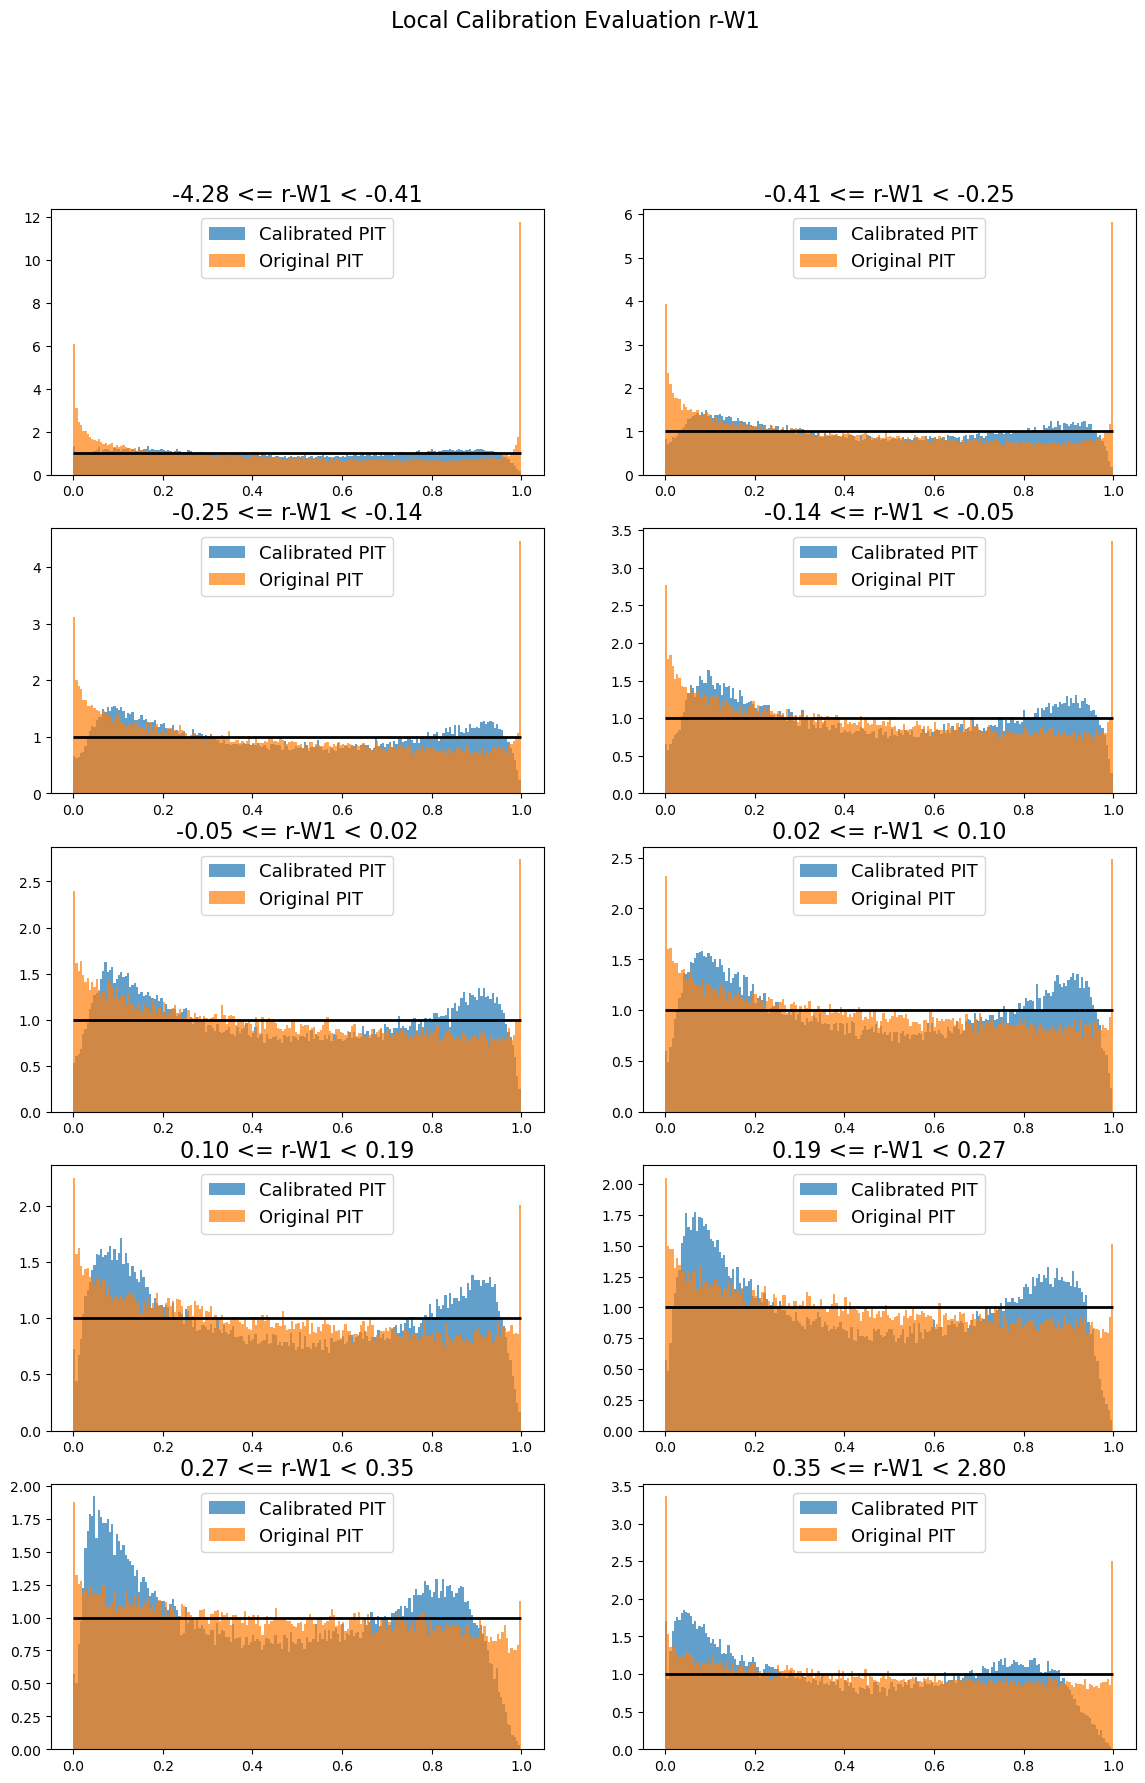

In [63]:
# quantiles in r-W1
#g-r = 18
#r-W1 = 30
#i-W2 = 39
INDEX = 30
qBINS = np.linspace(0,1,11)
qs = np.quantile(x_test[:,INDEX],qBINS)


fig = plt.figure(figsize=(14,20))
for j,i in enumerate(qs[0:-1]):
    plt.subplot(5,2,j+1)
    mask = np.logical_and(qs[j]<=x_test[:,INDEX],x_test[:,INDEX]<qs[j+1])

    n1, __, __  = plt.hist(new_cde_pit[mask], bins = 200, alpha = .7, label = 'Calibrated PIT',density=True)
    n2, __, __  = plt.hist(og_cde_pit[mask], bins = 200, alpha = .7, label = 'Original PIT',density=True)
    maxi = max([np.max(n1),np.max(n2)])
    if maxi > 15:
        plt.ylim(0,15)
    plt.title('{:.2f} <= r-W1 < {:.2f}'.format(qs[j],qs[j+1]),fontsize=16)
    plt.hlines(1.0,0.0,1.0,color='k',linewidth=2)
    
    plt.legend(loc='upper center',fontsize=13)

plt.suptitle('Local Calibration Evaluation r-W1',fontsize=16)
plt.savefig('../IMAGES/calpit_localfeature_rW1.png',dpi=600)
plt.show()

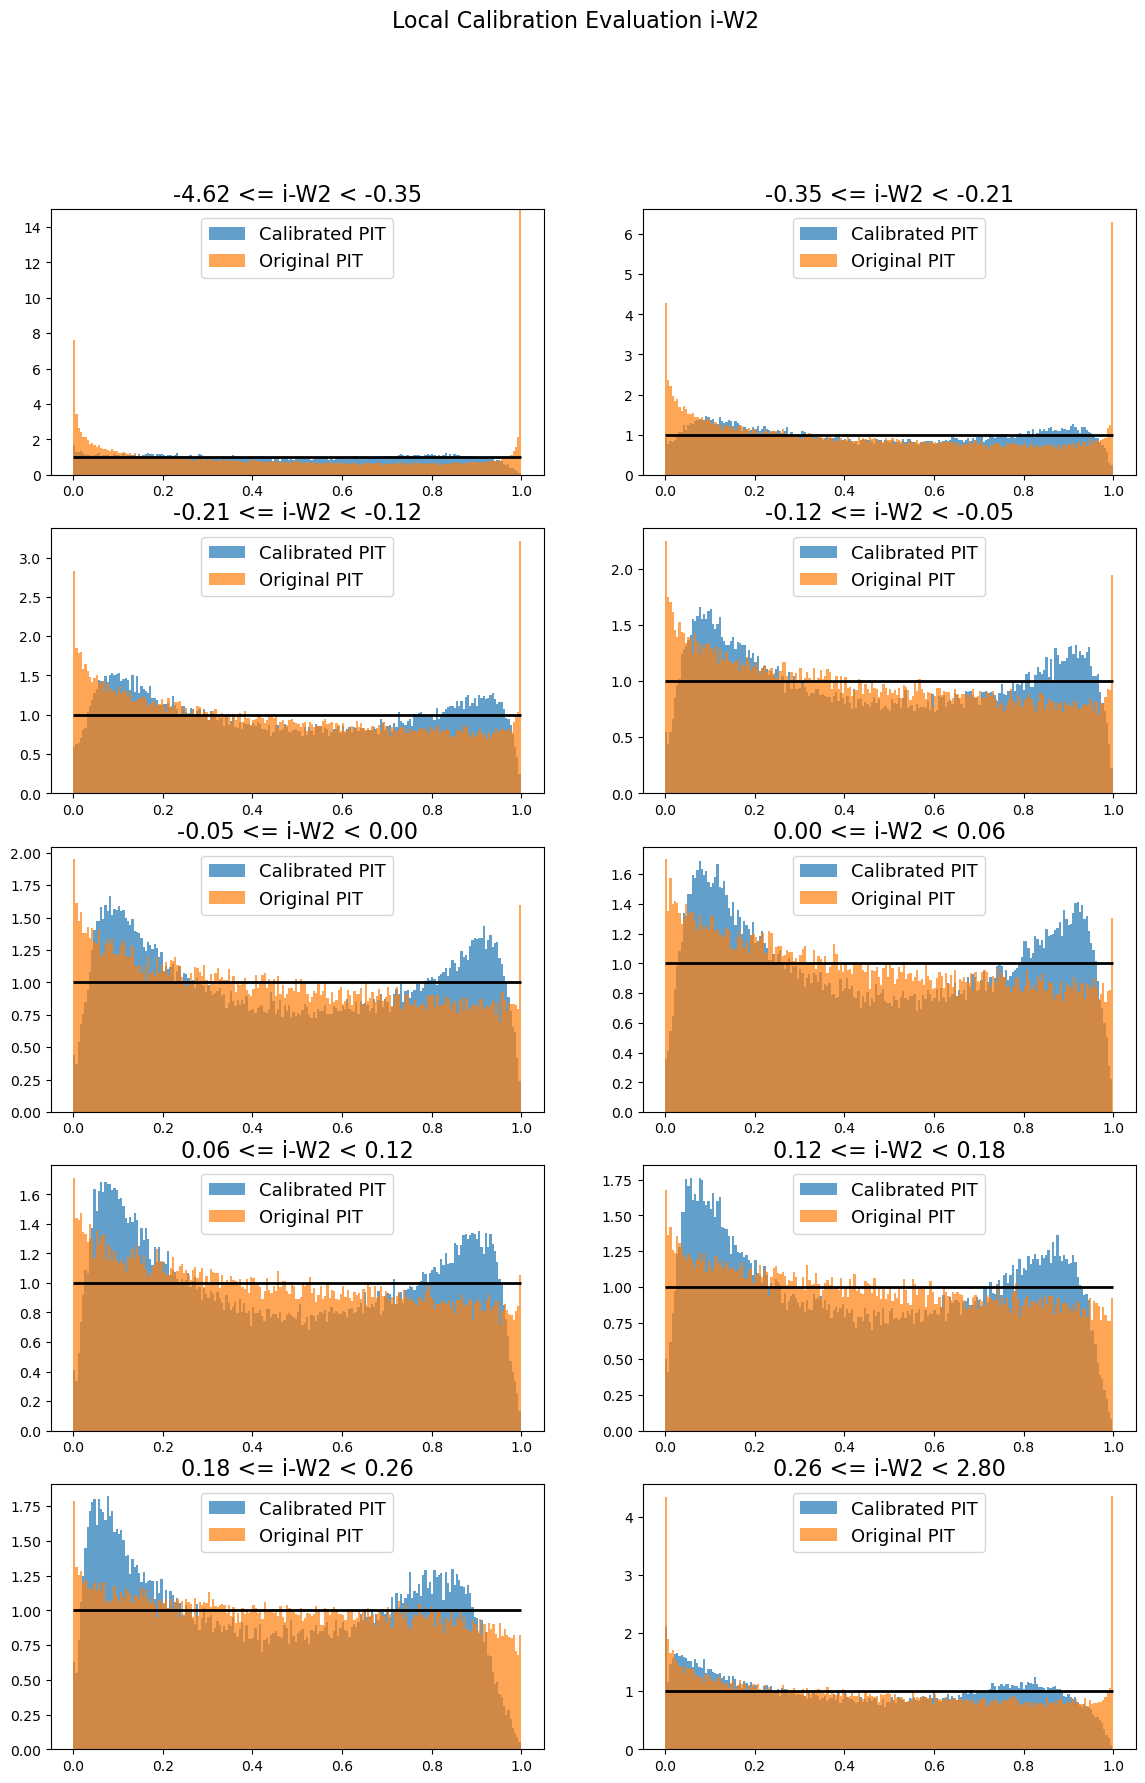

In [64]:
# quantiles in g-r
#g-r = 18
#r-W1 = 30
#i-W2 = 39
INDEX = 39
qBINS = np.linspace(0,1,11)
qs = np.quantile(x_test[:,INDEX],qBINS)


fig = plt.figure(figsize=(14,20))
for j,i in enumerate(qs[0:-1]):
    plt.subplot(5,2,j+1)
    mask = np.logical_and(qs[j]<=x_test[:,INDEX],x_test[:,INDEX]<qs[j+1])

    n1, __, __  = plt.hist(new_cde_pit[mask], bins = 200, alpha = .7, label = 'Calibrated PIT',density=True)
    n2, __, __  = plt.hist(og_cde_pit[mask], bins = 200, alpha = .7, label = 'Original PIT',density=True)
    maxi = max([np.max(n1),np.max(n2)])
    if maxi > 15:
        plt.ylim(0,15)
    plt.title('{:.2f} <= i-W2 < {:.2f}'.format(qs[j],qs[j+1]),fontsize=16)
    plt.hlines(1.0,0.0,1.0,color='k',linewidth=2)
    
    plt.legend(loc='upper center',fontsize=13)

plt.suptitle('Local Calibration Evaluation i-W2',fontsize=16)
plt.savefig('../IMAGES/calpit_localfeature_iW2.png',dpi=600)
plt.show()